<center><h1 class="list-group-item list-group-item-success">COVID-19/SARS B-cell Epitope Prediction</center>

## Introduction
Due to spread of COVID-19, vaccine development is beingdemanded as soon as possible. Despite the importance of data analysis in vaccine development, there are not many simple data sets that data analysts can handle. We published the dataset and the sample code for Bcell epitope prediction, one of the key research topics in vaccine development, available for free. This dataset was developed during our research process and the data contained in it was obtained from IEDB and UniProt. We would like to express our deepest gratitude to everyone who helped us. We briefly describe the B-cell epitope predictions covered by this dataset.  For details, please refer to our paper, our blog (only in Japanese), and others. B-cells inducing antigen-specific immune responses in vivo produce large amounts of antigen-specific antibodies by recognizing the subregions (epitope regions) of antigen proteins. They can inhibit their functioning by binding antibodies to antigen proteins. Predicting of epitope regions is beneficial for the design and development of vaccines aimed to induce antigen-specific antibody production. We believe that this dataset and code will be widely useful not only for COVID-19 but also for future medical data analysis.

Information on whether or not an amino acid peptide exhibited antibody-inducing activity (marked by an activity label) could be obtained from IEDB, which was used in many previous studies. Accordingly, this information was used as the label data. We also obtained the epitope candidate amino acid sequences (peptides) and the activity label data from the B-cell epitope data provided in IEDB. The presented antibody proteins were restricted to IgG that constituted the most recorded type in IEDB. For convenience, we excluded records representing different quantitative measures of antibody activity for the same peptide from experiments. The epitope data obtained from IEDB corresponded to the five types of activity: "Positive-High," "Positive-Intermediate," "Positive-Low," "Positive," and "Negative." However, due to the limited number of data elements marked with the "Positive-High," "Positive-Intermediate," and "Positive-Low" labels, we equally considered these labels as "Positive", thereby attributing the task to a binary estimation.

"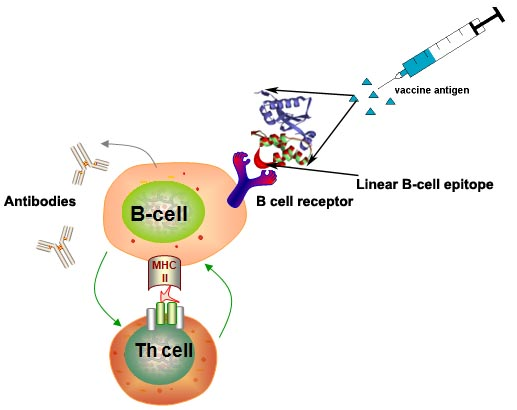
## Content
This contains three data files:

<b>input_bcell.csv</b> : this is our main training data. 
The number of rows is 14387 for all combinations of 14362 peptides and 757 proteins.<br>
<b>input_sars.csv</b> : this is also our main training data. The number of rows is 520.<br>
<b>input_covid.csv</b> : this is our target data. there is no label data in columns.<br>

All of three datasets consists of information of protein and peptide:

<b>parent_protein_id</b> : parent protein ID<br>
<b>protein_seq</b> : parent protein sequence<br>
<b>start_position</b> : start position of peptide<br>
<b>end_position</b> : end position of peptide<br>
<b>peptide_seq</b> : peptide sequence<br>
<b>chou_fasman</b> : peptide feature, β turn<br>
<b>emini</b> : peptide feature, relative surface accessibility<br>
<b>kolaskar_tongaonkar</b> : peptide feature, antigenicity<br>
<b>parker</b> : peptide feature, hydrophobicity<br>
<b>isoelectric_point</b> : protein feature<br>
<b>aromacity</b>: protein feature<br>
<b>hydrophobicity</b> : protein feature<br>
<b>stability</b> : protein feature<br>
<b>target</b> : antibody valence (target value)

## Overview
<font size = 3.5 color = "blue">
<li>Importing Packages</li>
<li>Importing Data</li>
<li>Analysing Data</li>
<li>Data Overview</li>
<li>Data Preprocessing</li>
<li>Data Visualization</li>
<li>Data Upscaling</li>
<li>Models Comparison</li>
<li>Data Normalization</li>
<li>Training Models</li>
<li>Evaluation Metrics</li>


# Importing Packages

In [ ]:
!pip install pycaret
!pip install sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,mean_squared_error,mean_absolute_error,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import pandas_profiling as pp
from imblearn.over_sampling import SMOTE

# Importing Data

In [ ]:
df_1 = pd.read_csv("../input/epitope-prediction/input_bcell.csv")
df_2 = pd.read_csv("../input/epitope-prediction/input_sars.csv")
df_test = pd.read_csv("../input/epitope-prediction/input_covid.csv")

In [ ]:
df_train = pd.concat([df_1,df_2])

# Analysing Data

In [ ]:
df_train.head()

In [ ]:
df_train.isnull().sum()

In [ ]:
df_train.corr()

In [ ]:
df_test.head()

# Data Overview

In [ ]:
pp.ProfileReport(df_train)

# Data Preprocessing

In [ ]:
def find_unique_length(df):
    list = []
    for i in df:
        if  len(i) not in list:
            list.append(len(i))
    return len(list)

In [ ]:
find_unique_length((df_train["protein_seq"]))

In [ ]:
len(df_train["protein_seq"].value_counts())

In [ ]:
find_unique_length(df_train["parent_protein_id"])

In [ ]:
len(df_train["parent_protein_id"].value_counts())

In [ ]:
df_train.dtypes

In [ ]:
df_train['protein_seq_length'] = df_train['protein_seq'].astype(str).map(len)
df_train['peptide_seq_length'] = df_train['peptide_seq'].astype(str).map(len)
df_train['parent_protein_id_length'] = df_train['parent_protein_id'].astype(str).map(len)

In [ ]:
df_train['peptide_length']=df_train['end_position'] - df_train['start_position'] + 1

In [ ]:
df_train.head()

In [ ]:
df_train.corr()

# Data Visualization

In [ ]:
num_vars=[x for x in df_train.columns if df_train[x].dtypes!='O']

In [ ]:
for i in num_vars:
    fig=px.box(df_train, y=i, color='target')
    fig.show()

In [ ]:
fig, axes=plt.subplots(8,2, figsize=(20,20))
for i,j in enumerate(num_vars):
    ax=axes[int(i/2), i%2]
    sns.kdeplot(df_train[j], ax=ax)

In [ ]:
df_train = df_train.drop(["parent_protein_id","protein_seq","peptide_seq","start_position","end_position"],axis =1)

In [ ]:
df_train.head()

# Data Upscaling

In [ ]:
X = df_train.drop("target",axis = 1)
Y = df_train["target"]

In [ ]:
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

In [ ]:
df_train = pd.concat([X,Y],axis = 1)

In [ ]:
train,test = train_test_split(df_train, test_size=0.1,random_state= 27)

# Models Comparison

In [ ]:
experiment = setup(
    data = train,
    target = 'target',
    normalize = True
)

In [ ]:
compare_models()

# Data Normalization

In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', Y_train.shape)
print('Testing Labels Shape:', Y_test.shape)

# Training Model

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [ ]:
rf.fit(X_train,Y_train)

In [ ]:
Y_pred_rf = rf.predict(X_test)

In [ ]:
etf = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [ ]:
etf.fit(X_train, Y_train)

In [ ]:
Y_pred_etf = etf.predict(X_test)

# Evaluation Metrics

In [ ]:
print(accuracy_score(Y_pred_rf,Y_test))

In [ ]:
print(confusion_matrix(Y_pred_rf,Y_test))

In [ ]:
print(classification_report(Y_pred_rf,Y_test))

In [ ]:
print(accuracy_score(Y_pred_etf,Y_test))

In [ ]:
print(confusion_matrix(Y_pred_etf,Y_test))

In [ ]:
print(classification_report(Y_pred_etf,Y_test))

### Extra trees classifier performs better than Random forest !! 😀

![]("https://i.pinimg.com/originals/86/74/a9/8674a918f3765e5ab9f1191ad5811713.gif")

![image info](https://i.pinimg.com/originals/86/74/a9/8674a918f3765e5ab9f1191ad5811713.gif)

## Thank You 🤗
### I hope you had a good time reading my notebook. Pls do support and comment! 😎